In [614]:
#imports
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from colorama import Fore

In [615]:
#read files
os.chdir(r'C:\Users\Yael\.ipynb_checkpoints\datasets')
data = {
'megaline_calls' : pd.read_csv('megaline_calls.csv'),
'megaline_internet' : pd.read_csv('megaline_internet.csv'),
'megaline_messages' : pd.read_csv('megaline_messages.csv'),
'megaline_tariffs' : pd.read_csv('megaline_tariffs.csv'),
'megaline_users' : pd.read_csv('megaline_users.csv')
}

In [616]:
#view general information
for name, file in data.items():
    print(Fore.BLUE, name, Fore.GREEN)
    print('\n', file.info(), Fore.YELLOW, file.describe(),'\n',Fore.BLACK, file.head(10),'\n')

 megaline_calls 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB

 None               user_id       duration
count  137735.000000  137735.000000
mean     1247.658046       6.745927
std       139.416268       5.839241
min      1000.000000       0.000000
25%      1128.000000       1.290000
50%      1247.000000       5.980000
75%      1365.000000      10.690000
max      1499.000000      37.600000 
           id  user_id   call_date  duration
0   1000_93     1000  2018-12-27      8.52
1  1000_145     1000  2018-12-27     13.66
2  1000_247     1000  2018-12-27     14.48
3  1000_309     1000  2018-12-28      5.76
4  1000_380     1000  2018-12-30      4.22
5  1000_388     1000  2018-12-31      2.20
6  1000_510     1000  2018-12-2

## Preprocessing

#### Conversions

In [617]:
#renaming dates column in usage data to have the same name
data['megaline_calls'].rename(columns={'call_date':'date'}, inplace=True)
data['megaline_internet'].rename(columns={'session_date':'date'}, inplace=True)
data['megaline_messages'].rename(columns={'message_date':'date'}, inplace=True)

In [618]:
#conveting dates to timestamp
for df in ['megaline_calls','megaline_internet','megaline_messages']:
    data[df]['date'] = pd.to_datetime(data[df]['date'])
#data['megaline_calls']['date'].describe()

In [619]:
#conveting dates in megaline_users to timestamp
data['megaline_users']['reg_date'] = pd.to_datetime(data['megaline_users']['reg_date'])
#data['megaline_users']['reg_date'].describe
data['megaline_users']['churn_date'] = pd.to_datetime(data['megaline_users']['churn_date'])
#data['megaline_users']['churn_date'].describe()

#### Cleansing

In [620]:
#counting the number of 0 min calls (the first quartile is less than 1.29)
100*data['megaline_calls'].query('duration==0')['duration'].count() / data['megaline_calls'].shape[0]

19.48233927469416

About 20% of all calls lasts 0 minutes, probably call that weren't answered.

In [621]:
#evaluating quartiles when slicing only calls duration > 0
data['megaline_calls'][data['megaline_calls']['duration']>0].describe()

,user_id,duration
count,110901.000000,110901.000000
mean,1247.511871,8.378196
std,139.475249,5.354567
min,1000.000000,0.010000
25%,1127.000000,4.150000
50%,1247.000000,7.710000
75%,1365.000000,11.820000
max,1499.000000,37.600000


When eliminating duration=0 the first quartile moves from 1.29 to 4.15

In [622]:
#counting the number of 0 mb sessions 
data['megaline_internet'].query('mb_used == 0')['mb_used'].count() / data['megaline_internet'].shape[0]

0.1311423801574052

About 13% of all sessions are 0 mb, probably due to a few kb sessions that were rounded to zero.

In [623]:
#evaluating quartiles when slicing only calls duration > 0
data['megaline_internet'][data['megaline_internet']['mb_used']>0].describe()

,user_id,mb_used
count,91078.000000,91078.000000
mean,1242.576923,422.064206
std,141.992374,255.063501
min,1000.000000,0.010000
25%,1122.000000,223.380000
50%,1236.000000,395.905000
75%,1367.000000,588.367500
max,1499.000000,1693.470000


When eliminating mb_used=0 the first quartile moves from 136 to 255 mb

In [624]:
#detecting usage out of reg/churn dates

#creating empty df for each type
usage_outofdate = {}
for df in ['megaline_calls','megaline_internet','megaline_messages']:
    usage_outofdate[df] = pd.DataFrame(columns=['user_id', 'id', 'date'])
users_months = pd.DataFrame(columns=['user_id', 'date'])
    
#iterating over users to find event out of dates
i=0
for user in list(data['megaline_users']['user_id']):
    for df in ['megaline_calls','megaline_internet','megaline_messages']:
        usage_outofdate[df] = usage_outofdate[df].append( \
                data[df].loc[(data[df]['user_id']==user) \
                        & ((data[df]['date'] > data['megaline_users'].iloc[i]['churn_date']) \
                          | (data[df]['date'] < data['megaline_users'].iloc[i]['reg_date'])), \
                             ['user_id', 'id', 'date']])
    
    #creating df with all usage months per user for future use
    for month in pd.date_range(start=data['megaline_users']['reg_date'][i], \
              end=min(pd.to_datetime('2018-12-31'), data['megaline_users']['churn_date'][i]), freq='M') \
              .to_period("M"):
        users_months = users_months.append({'user_id':user,'date':month}, ignore_index=True)
    i+=1

In [625]:
for df in ['megaline_calls','megaline_internet','megaline_messages']:
    print(usage_outofdate[df].shape[0] / data[df].shape[0])

0.02149780375358478
0.023496303362747436
0.020920171989848916


About 2% of records have incorrect dates so we can remove them

In [626]:
#removing out of date records
for df in ['megaline_calls','megaline_internet','megaline_messages']:
    data[df].drop(usage_outofdate[df].index, inplace=True)

#### Adding Calculations

In [627]:
#getting relevant months
print(data['megaline_users']['reg_date'].min(), data['megaline_users']['churn_date'].max())

2018-01-01 00:00:00 2018-12-31 00:00:00


In [629]:
#adding column with only yyyy-mm for monthly usage calculations
for df in ['megaline_calls','megaline_internet','megaline_messages']:
    data[df]['year_month']=data[df]['date'].dt.to_period("M")

In [630]:
#addind pivot tables calculations for number of calls, sms and minutes, mb used per month
data['megaline_monthly_usage'] = \
    data['megaline_calls'].pivot_table(index=['user_id','year_month'], values='duration', aggfunc=['count', 'sum']) \
    .reindex(users_months) \
    .join(data['megaline_messages'].pivot_table(index=['user_id','year_month'], values='id', aggfunc='count'), \
          how='left', lsuffix='_left', rsuffix='_right') \
    .join(data['megaline_internet'].pivot_table(index=['user_id','year_month'], values='mb_used', aggfunc='sum'), \
          how='left', lsuffix='_left', rsuffix='_right') \
    
data['megaline_monthly_usage'].columns = \
    ['calls_per_month', 'call_duration_per_month', 'messages_per_month', 'mb_per_month']              

C:\Users\Yael\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [631]:
data['megaline_monthly_usage']

calls_per_month  call_duration_per_month  \
user_id year_month                                             
1000    2018-12                16.0                   116.83   
1001    2018-08                27.0                   171.14   
        2018-09                49.0                   297.69   
        2018-10                65.0                   374.11   
        2018-11                64.0                   404.59   
...                             ...                      ...   
1499    2018-08                 NaN                      NaN   
        2018-09                41.0                   330.37   
        2018-10                53.0                   363.28   
        2018-11                45.0                   288.56   
        2018-12                65.0                   468.10   

                    messages_per_month  mb_per_month  
user_id year_month                                    
1000    2018-12                   11.0       1901.47  
1001    2018-08                   30.0       6919.15  
        2018-09                   44.0      13314.82  
        2018-10                   53.0      22330.49  
        2018-11                   36.0      18504.30  
...                                ...           ...  
1499    2018-08                    NaN           NaN  
        2018-09                    NaN      12984.76  
        2018-10                    NaN      19492.43  
        2018-11                    NaN      16813.83  
        2018-12                    NaN      22059.21  

[3283 rows x 4 columns]

In [632]:
#calculating mask indices for ultimate, surf users
ultimate_users = data['megaline_users'].loc[data['megaline_users']['tariff']=='ultimate','user_id']
ultimate_mask = data['megaline_monthly_usage'].eval('user_id in @ultimate_users')
surf_users = data['megaline_users'].loc[data['megaline_users']['tariff']=='surf','user_id']
surf_mask = data['megaline_monthly_usage'].eval('user_id in @surf_users')

In [633]:
#calculating monthly profit per user per month
i=0
for mask in [surf_mask, ultimate_mask]:
    tar=data["megaline_tariffs"].iloc[i,:] #the tariff row
    #calculate exceeded use for users
        #exceeded minutes per month
    data['megaline_monthly_usage'].loc[mask,'minutes_exceeded'] = np.maximum(0, \
        data['megaline_monthly_usage'].loc[mask,'call_duration_per_month'] \
        .sub(tar['minutes_included']))
        #exceeded messages per month
    data['megaline_monthly_usage'].loc[mask, 'messages_exceeded'] = np.maximum(0, \
        data['megaline_monthly_usage'].loc[mask,'messages_per_month'] \
        .sub(tar['messages_included']))
        #exceeded mb per month
    data['megaline_monthly_usage'].loc[mask,'mb_exceeded'] = np.maximum(0, \
        data['megaline_monthly_usage'].loc[mask,'mb_per_month'] \
        .sub(tar['mb_per_month_included']))
    
    #calculate total profit from users
    data['megaline_monthly_usage'].loc[mask,'profit_per_month'] = \
        (np.maximum(0,data['megaline_monthly_usage'].loc[mask,'minutes_exceeded']) \
         * tar['usd_per_minute']) \
        .add(np.maximum(0,data['megaline_monthly_usage'].loc[mask,'messages_exceeded']) \
             * tar['usd_per_message'], fill_value=0) \
          .add(np.maximum(0,data['megaline_monthly_usage'].loc[mask,'mb_exceeded']) \
               * (tar['usd_per_gb'] / 1024), fill_value=0) \
           .add(tar['usd_monthly_pay'],fill_value=0)
    i+=1

In [634]:
data['megaline_monthly_usage'].head(20)

calls_per_month  call_duration_per_month  \
user_id year_month                                             
1000    2018-12                16.0                   116.83   
1001    2018-08                27.0                   171.14   
        2018-09                49.0                   297.69   
        2018-10                65.0                   374.11   
        2018-11                64.0                   404.59   
        2018-12                56.0                   392.93   
1002    2018-10                11.0                    54.13   
        2018-11                55.0                   359.76   
        2018-12                47.0                   363.24   
1003    2018-01                 NaN                      NaN   
        2018-02                 NaN                      NaN   
        2018-03                 NaN                      NaN   
        2018-04                 NaN                      NaN   
        2018-05                 NaN                      NaN   
        2018-06                 NaN                      NaN   
        2018-07                 NaN                      NaN   
        2018-08                 NaN                      NaN   
        2018-09                 NaN                      NaN   
        2018-10                 NaN                      NaN   
        2018-11                 NaN                      NaN   

                    messages_per_month  mb_per_month  minutes_exceeded  \
user_id year_month                                                       
1000    2018-12                   11.0       1901.47               0.0   
1001    2018-08                   30.0       6919.15               0.0   
        2018-09                   44.0      13314.82               0.0   
        2018-10                   53.0      22330.49               0.0   
        2018-11                   36.0      18504.30               0.0   
        2018-12                   44.0      19369.18               0.0   
1002    2018-10                   15.0       6552.01               0.0   
        2018-11                   32.0      19345.08               0.0   
        2018-12                   41.0      14396.24               0.0   
1003    2018-01                    NaN           NaN               NaN   
        2018-02                    NaN           NaN               NaN   
        2018-03                    NaN           NaN               NaN   
        2018-04                    NaN           NaN               NaN   
        2018-05                    NaN           NaN               NaN   
        2018-06                    NaN           NaN               NaN   
        2018-07                    NaN           NaN               NaN   
        2018-08                    NaN           NaN               NaN   
        2018-09                    NaN           NaN               NaN   
        2018-10                    NaN           NaN               NaN   
        2018-11                    NaN           NaN               NaN   

                    messages_exceeded  mb_exceeded  profit_per_month  
user_id year_month                                                    
1000    2018-12                   0.0         0.00         70.000000  
1001    2018-08                   0.0         0.00         20.000000  
        2018-09                   0.0         0.00         20.000000  
        2018-10                   3.0      6970.49         88.161191  
        2018-11                   0.0      3144.30         50.706055  
        2018-12                   0.0      4009.18         59.152148  
1002    2018-10                   0.0         0.00         20.000000  
        2018-11                   0.0      3985.08         58.916797  
        2018-12                   0.0         0.00         20.000000  
1003    2018-01                   NaN          NaN         20.000000  
        2018-02                   NaN          NaN         20.000000  
        2018-03                   NaN          NaN         

## Analysis

In [635]:
#calculate usage and profit statistics per plan

stat={}
for plan,mask in zip(['surf','ultimate'],[surf_mask,ultimate_mask]):
    stat[plan]=pd.concat([data['megaline_monthly_usage'].loc[mask,:].median(), \
                        data['megaline_monthly_usage'].loc[mask,:].mean(), \
                        data['megaline_monthly_usage'].loc[mask,:].var(), \
                        data['megaline_monthly_usage'].loc[mask,:].std(), \
                        data['megaline_monthly_usage'].loc[mask,:].min(), \
                        data['megaline_monthly_usage'].loc[mask,:].max()], axis=1)
    stat[plan].columns=['median','mean','var','std','min','max']
    stat[plan]=stat[plan].round(1)
    print(plan , 'statistics\n',stat[plan],'\n\n')   

surf statistics
                           median     mean         var     std   min      max
calls_per_month             60.0     60.8       987.0    31.4   1.0    205.0
call_duration_per_month    405.6    411.6     47475.1   217.9   0.0   1431.2
messages_per_month          32.0     39.9      1100.7    33.2   1.0    266.0
mb_per_month             16922.1  16704.7  62437415.2  7901.7  92.3  70931.6
minutes_exceeded             0.0     50.0     12496.4   111.8   0.0    931.2
messages_exceeded            0.0      9.0       474.5    21.8   0.0    216.0
mb_exceeded               1562.1   3674.0  29709909.6  5450.7   0.0  55571.6
profit_per_month            20.0     45.6      2296.6    47.9  20.0    581.3 


ultimate statistics
                           median     mean         var     std    min      max
calls_per_month             61.0     61.3      1086.7    33.0    2.0    191.0
call_duration_per_month    403.6    410.8     50855.2   225.5    0.0   1292.1
messages_per_month          41.0

- The medians are pretty much the same for surf and ultimate users 
- The main exception is mb_exceeded which is more common for surf users. 
- Ultimate users never exceed their minutes and sms limits.
- It's interesting to note that the max usage values are higher for surf users, although they bought a liter plan.
- Total profit per month has a median = monthly charge for both plans
- About half of surf users has extra charges 
- The majority of ultimate users doesn't have extra charges (median=mean, very small std)

C:\Users\Yael\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Yael\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


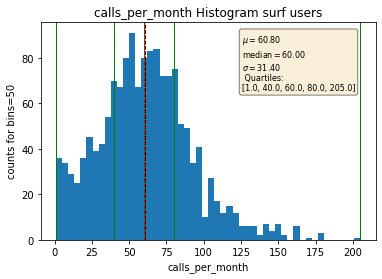

<Figure size 1440x360 with 0 Axes>

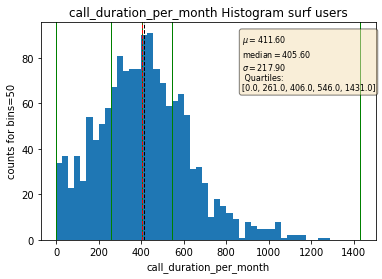

<Figure size 1440x360 with 0 Axes>

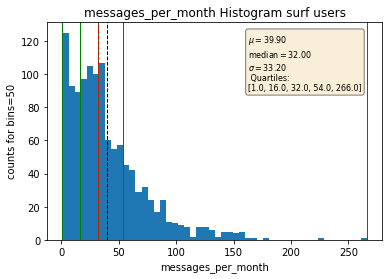

<Figure size 1440x360 with 0 Axes>

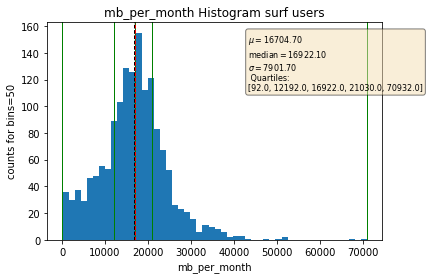

<Figure size 1440x360 with 0 Axes>

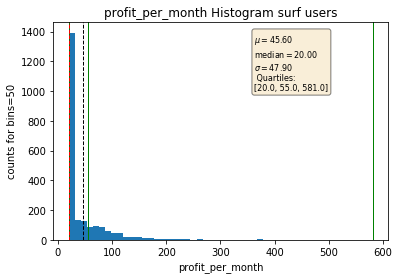

<Figure size 1440x360 with 0 Axes>

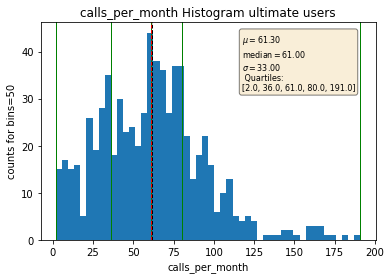

<Figure size 1440x360 with 0 Axes>

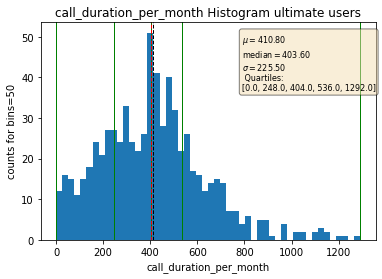

<Figure size 1440x360 with 0 Axes>

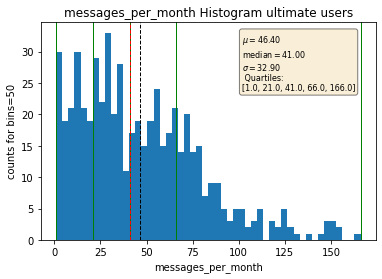

<Figure size 1440x360 with 0 Axes>

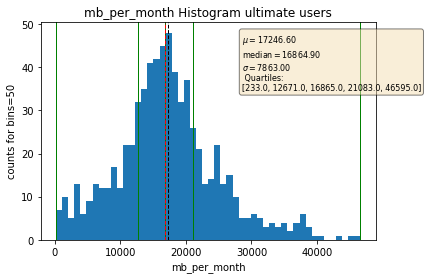

<Figure size 1440x360 with 0 Axes>

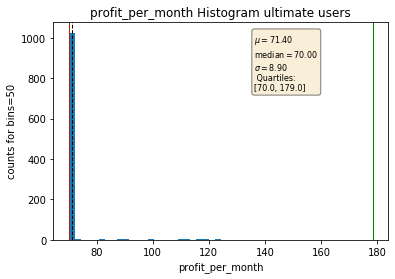

<Figure size 1440x360 with 0 Axes>

In [636]:
#plot histograms for monthly usages and monthly profit for each plan
for plan,mask in zip(['surf','ultimate'],[surf_mask,ultimate_mask]):
     for col in ['calls_per_month', 'call_duration_per_month', 'messages_per_month', 'mb_per_month','profit_per_month']:
        #plotting histograms      
        fig, ax = plt.subplots()
        plt.hist(data['megaline_monthly_usage'].loc[mask,col], \
                 range=(stat[plan].loc[col,'min'],stat[plan].loc[col,'max']), bins=50)
        plt.xlabel(col)
        plt.ylabel('counts for bins=50')
        plt.title(col+' Histogram '+plan+' users')
        #adding quartiles
        quartiles = pd.qcut(data['megaline_monthly_usage'].loc[mask,col],4,retbins=True,duplicates='drop',precision=0)
        for q in range(len(quartiles[1])):
            plt.axvline(quartiles[1][q], color='g', linewidth=1)
            quartiles[1][q]=round(quartiles[1][q])
        #adding mean and median
        plt.axvline(stat[plan].loc[col,'mean'], color='k', linestyle='dashed', linewidth=1)
        plt.axvline(stat[plan].loc[col,'median'], color='r', linestyle='dashed', linewidth=1)
        plt.figure(figsize=(20,5))
        #adding statistics values on figure
        textstr = '\n'.join((
        r'$\mu=%.2f$' % (stat[plan].loc[col,'mean'], ),
        r'$\mathrm{median}=%.2f$' % (stat[plan].loc[col,'median'], ),
        r'$\sigma=%.2f$' % (stat[plan].loc[col,'std'] ),
        ' Quartiles:',str(list(quartiles[1]))))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.6, 0.95, textstr, transform=ax.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)

In [637]:
#what part of surf users pay more than monthly charge
data['megaline_monthly_usage'].query('profit_per_month > 20').loc[surf_mask,'profit_per_month'].count() \
/ data['megaline_monthly_usage'].loc[surf_mask,'profit_per_month'].count()

0.48963963963963963

In [638]:
#what part of ultimate users pay more than monthly charge
data['megaline_monthly_usage'].query('profit_per_month > 70').loc[ultimate_mask,'profit_per_month'].count() \
/ data['megaline_monthly_usage'].loc[ultimate_mask,'profit_per_month'].count()

0.03762935089369708

Surf users:
- number of call per month is somewhat gaussian around mean=60 calls and std=0.5mean
- call duration behaves the same around mean=411 minutes
- messages per month has more users for small values and is decreasing but not continuously
- traffic volume is somewhat gaussian around mean=16GB with std ~= 0.5mean
- the profit from half of the users is the monthly charge 20
- the other half is responsible for profit between 20-581 and increase the average profit to mean=45 ~ twice as the monthly charge, and std is very large ~ mean

Ultimate users:
- number of call per month is somewhat gaussian around mean=60 calls and std=0.5mean but with much more fluctuations than surf
- call duration behaves the same around mean=410 minutes 
- messages per month has almost similar statistics to surf but with more fluctuation, the decrease with number of messages starts to be significant at 75 messages per month.
- traffic volume is somewhat gaussian around mean=16GB with std ~= 0.5mean
- the profit from 0.96 of users is the monthly charge 70
- only 0.04 of users exeed the plan and pay between 70-179 with very low std

The average monthly profit is 45 from surf user and 70 from ultimate user, while the average usage is pretty much the same for both. Thus in a large scale it's more profitable to sell ultimate plans than surf plans. 
Ultimate plans have another advantage of predictable monthly income, which is more variant in surf plans with large std.

## Hypotheses

### The company earns different amounts from the Ultimate and Surf plans (measured in terms of average monthly revenue)

The null H0 hypotheses to be tested is "The mean of Ultimate profit per month is equal to the mean of Surf profit per month"
The alternative is "The mean of Ultimate profit per month is not equal to the mean of Surf profit per month"
==> a two sided test is necessary.

Choosing alpha:
Examining the two possible wrong results:

- False-Negative, p<alpha when H0 is actually true in reality.
    In this case we'll reject H0 and reccomend to sell more of one plan. The result is the company will give more resources for the "better plan" marketing , but the overall profit will stay similar in a large scale because H0 is true and the planss' profits behave the same. ==> no significant loss for false negative (in terms of revenue, not in terms of net income)

-False-Positive, p>alpha when H0 is actually False in reality.
    In this case we will not reject H0 and reccomend to sell the same of both plans. The result is selling too many less-profitable plans instead of more-profitable plans. Let's assume Ultimate has average profit greater than Surf. 
    That will give the company an average "loss" per wrong-sold surf plan of about 0-50, let's assume 25.
    
Thus, in terms of revnue, it's much more important to avoid False-Positive than to avoid False-Negative.
In combination with the fact that the sample is quite big and less vulnerable to random shifts, it means it's better to choose alpha a little larger than conservative value. 

I chose to take alpha=0.2, meaning to reject H0 if there's a chance of less than 20% to get these distributions randomly.

In [639]:
#ttesing H0
alpha = 0.2

results = stats.ttest_ind(
        data['megaline_monthly_usage'].loc[surf_mask,'profit_per_month'], 
        data['megaline_monthly_usage'].loc[ultimate_mask,'profit_per_month'], equal_var=False)# does not assume equal population variance

print('p-value:',results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 3.5229267631543866e-119
We reject the null hypothesis


The p value is extremely small, indicating that we should accept the alternative: "The mean of Ultimate profit per month is not equal to the mean of Surf profit per month"

### Average monthly revenue from users in the NY-NJ area differs from that in other regions.

The null H0 hypotheses to be tested is "The mean of profit per month from NY-NJ users is equal to the mean of  profit per month in other regions"
The alternative is "The mean of profit per month from NY-NJ users is not equal to the mean of  profit per month in other regions"
==> a two sided test is necessary.

- False-Negative - rejecting H0 will result in reccomendation to put greater/smaller marketing resources in NY-NJ when it's actually unneccesary. The revenue shouldn't change.

- False-Positive - not rejecting H0 will result in reccomendation to treat NY-NJ just the same when there's actually a greater/smaller potential fot profit in this area. The revenue will decrease compared to a situation of greater marketing where users bring more money.

Again it's more important to avoid False-Positive in terms of revenue, meaning greater alpha.

I chose alpha=0.1

In [640]:
NYNJ_users = data['megaline_users'].loc[data['megaline_users']['city']=='New York-Newark-Jersey City, NY-NJ-PA MSA','user_id']
NYNJ_mask = data['megaline_monthly_usage'].eval('user_id in @NYNJ_users')
other_mask = data['megaline_monthly_usage'].eval('user_id not in @NYNJ_users')
#ttesing H0
alpha = 0.1

results = stats.ttest_ind(
        data['megaline_monthly_usage'].loc[NYNJ_mask,'profit_per_month'], 
        data['megaline_monthly_usage'].loc[other_mask,'profit_per_month'], equal_var=False)# does not assume equal population variance

print('p-value:',results.pvalue)

if (results.pvalue < alpha):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value: 0.019779705397045197
We reject the null hypothesis


p value is quite small, inidicating a chance of 2% to get these values randomly, and it would be ok to accept the alternative "The mean of profit per month from NY-NJ users is not equal to the mean of  profit per month in other regions"

## Conclusion

- Surf and Ultimate plans have similar statistics regarding monthly call duration, number of messages and traffic volume.
- Ultimate users have more fluctuations in usage
- The usage is quite similar although Ultimate users have lager limits
- Half of surf users exceed monthly charge, compared to 0.04 of Ultimate users
- Average monthly profit from Surf user is 45, compared to 70from Ultimate user
- Ultimate monthly profit is stable and predictable, unlike Surf monthly profit with large variance
- TTest shows very clearly that average monthly revenue is different for the two plans and that it's not a random case
- All the above makes it possible to conclude that Ultimate plan may be more profitable even in terms of net profit
- Profit differs significanly between cities